In [47]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import quad
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info.operators import SuperOp, Choi, Kraus
from qiskit.providers.aer.pulse_new.models.signals import Constant, Signal
from qiskit.providers.aer.pulse_new.models.quantum_models import HamiltonianModel, QuantumSystemModel
from qiskit.providers.aer.pulse_new.de.DE_Problems import SchrodingerProblem, LindbladProblem, LindbladianProblem
from qiskit.providers.aer.pulse_new.de.DE_Options import DE_Options
from qiskit.providers.aer.pulse_new.de.solve import solve

X = Operator.from_label('X')
Y = Operator.from_label('Y')
Z = Operator.from_label('Z')

# 1. Signals

In [2]:
def gaussian(amp, sig, t0, t):
    return amp * np.exp( -(t - t0)**2 / (2 * sig**2) )

In [3]:
amp = 1.
sig = 2.
t0 = 3.5*sig
T = 7*sig

gauss_signal = Signal(envelope=lambda t: gaussian(amp, sig, t0, t), 
                      carrier_freq=0.5)

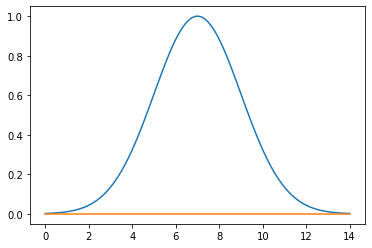

In [4]:
gauss_signal.plot_envelope(0, T, 100)

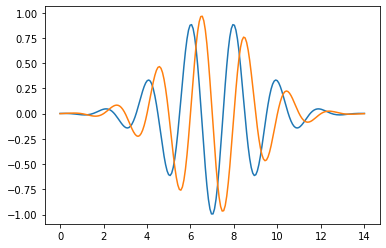

In [5]:
gauss_signal.plot(0, T, 200)

# 2. The `HamiltonianModel` class

A `HamiltonianModel` is specified as a list of Hermitian operators with `Signal` coefficients.

In [6]:
r = 0.5
w = 1.
amp = 1.
sig = 0.399128/r
t0 = 3.5*sig
T = 7*sig
signals = [Constant(1.),
           Signal(envelope=lambda t: gaussian(amp, sig, t0, t), carrier_freq=w)]
operators = [2 * np.pi * w * Z/2, 
             2 * np.pi * r * X/2]

hamiltonian = HamiltonianModel(operators=operators, signals=signals)

Evaluate at a given time.

In [7]:
print(hamiltonian.evaluate(0.1))

[[ 3.14159265+0.j  0.00427597+0.j]
 [ 0.00427597+0.j -3.14159265+0.j]]


Get the drift (terms corresponding to `Constant` coefficients). In this case just the first term.

In [8]:
hamiltonian.drift

array([[ 3.14159265+0.j,  0.        +0.j],
       [ 0.        +0.j, -3.14159265+0.j]])

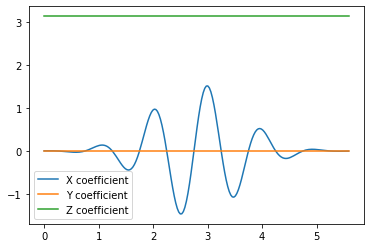

In [9]:
def plot_qubit_hamiltonian_components(hamiltonian, t0, tf, N=200):
    t_vals = np.linspace(t0, tf, N)
    model_vals = np.array([hamiltonian.evaluate(t) for t in t_vals])
    x_coeff = model_vals[:, 0, 1].real
    y_coeff = -model_vals[:, 0, 1].imag
    z_coeff = model_vals[:, 0, 0].real
    plt.plot(t_vals, x_coeff, label='X coefficient')
    plt.plot(t_vals, y_coeff, label='Y coefficient')
    plt.plot(t_vals, z_coeff, label='Z coefficient')
    plt.legend()

plot_qubit_hamiltonian_components(hamiltonian, 0., T)

## 2. Enter a frame

In this case, we will enter the frame of the drift.

In [10]:
hamiltonian.frame = hamiltonian.drift

Evaluate again.

In [11]:
print(hamiltonian.evaluate(0.1))

[[-4.4408921e-16+0.j          3.4593352e-03+0.00251335j]
 [ 3.4593352e-03-0.00251335j  4.4408921e-16+0.j        ]]


In the above, the diagonal part of the model is now $0$, as it has been subtracted when entering the frame (which is coincidentally the diagonal). The off-diagonal part, which ordinarily is $2 \pi r X / 2$ multiplied with an oscillating signal, is now rotating between $X$ and $Y$ as a result of being in the frame. We can plot the real and imaginary parts of the first off-diagonal to see this.

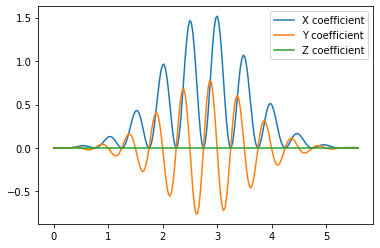

In [12]:
plot_qubit_hamiltonian_components(hamiltonian, 0., T)

In the above, the real part is blue, corresponding to the $X$ operator, and the imaginary part is yellow, corresponding to the $Y$ operator.

# 3. Set cutoff frequency

Next, we add a cutoff frequency, which eliminates terms in the model oscillating above a given frequency. The frequencies for a given term are a combination of oscillations due to the chosen frame, as well as oscillations due to signal carrier frequencies.

The classic RWA uses the model we have defined, and sets the cutoff to `2*w`.

In [13]:
hamiltonian.cutoff_freq = 2*w

We now perform the same plot as above.

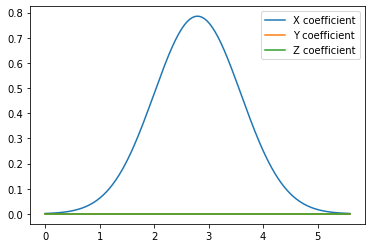

In [14]:
plot_qubit_hamiltonian_components(hamiltonian, 0., T)

Observe, the real part is now constant at $\pi /2$, which is the average of the oscillation in the previous section (similarly, the imaginary part is constant at the corresponding average of $0$).

# 4. Solve Shrodinger equation with a HamiltonianModel

In [15]:
r = 0.1
w = 1.
amp = 1.
sig = 0.399128/r
t0 = 3.5*sig
T = 7*sig
signals = [Constant(1.),
           Signal(envelope=lambda t: gaussian(amp, sig, t0, t), carrier_freq=w)]
operators = [2 * np.pi * w * Z/2, 
             2 * np.pi * r * X/2]

hamiltonian = HamiltonianModel(operators=operators, signals=signals)
se_problem = SchrodingerProblem(hamiltonian=hamiltonian, y0=np.array([0., 1.]), interval=[0., T])

In [16]:
options = DE_Options(atol=1e-10, rtol=1e-10)
%time y = solve(se_problem, options)
print("\nFinal state:")
print("----------------------------")
print(y)
print("\nPopulation in excited state:")
print("----------------------------")
print(np.abs(y[0])**2)

CPU times: user 584 ms, sys: 2.72 ms, total: 586 ms
Wall time: 586 ms

Final state:
----------------------------
[0.19057907-0.98161606j 0.00209799+0.01025322j]

Population in excited state:
----------------------------
0.9998904699358702


Note: the RWA is not a great approximation for this system, hence the state not being inverted very well.

In [17]:
# Solving with no frame
se_problem_lab_frame = SchrodingerProblem(hamiltonian=hamiltonian, 
                                          y0=np.array([0., 1.]), 
                                          interval=[0, T], 
                                          frame=None)
%time y = solve(se_problem_lab_frame, options)
print("\nFinal state:")
print("----------------------------")
print(y)
print("\nPopulation in excited state:")
print("----------------------------")
print(np.abs(y[0])**2)

CPU times: user 837 ms, sys: 11.2 ms, total: 848 ms
Wall time: 840 ms

Final state:
----------------------------
[0.19057907-0.98161606j 0.00209799+0.01025322j]

Population in excited state:
----------------------------
0.9998904604247696


In [18]:
# Solving with frame and cutoff freq
se_problem_lab_frame = SchrodingerProblem(hamiltonian=hamiltonian, 
                                          y0=np.array([0., 1.]), 
                                          interval=[0, T], 
                                          frame='auto',
                                          cutoff_freq=2*w)
%time y = solve(se_problem_lab_frame, options)
print("\nFinal state:")
print("----------------------------")
print(y)
print("\nPopulation in excited state:")
print("----------------------------")
print(np.abs(y[0])**2)

CPU times: user 54.7 ms, sys: 2.97 ms, total: 57.6 ms
Wall time: 55.3 ms

Final state:
----------------------------
[ 1.90589693e-01-9.81669786e-01j -8.52045953e-08+1.65423417e-08j]

Population in excited state:
----------------------------
1.0000000000232854


# 5. `QuantumSystemModel`

A model with a Hamiltonian and noise operators.

In [29]:
# construct Hamiltonian
r = 0.1
w = 1.
amp = 1.
sig = 0.399128/r
t0 = 3.5*sig
T = 7*sig
signals = [Constant(1.),
           Signal(envelope=lambda t: gaussian(amp, sig, t0, t), carrier_freq=w)]
operators = [2 * np.pi * w * Z/2, 
             2 * np.pi * r * X/2]

# construct quantum model with noise operators
noise_ops = [np.array([[0., 0.], 
                       [1., 0.]])]
noise_signals = [Constant(0.0001)]
q_model = QuantumSystemModel(hamiltonian=hamiltonian, 
                             noise_operators=noise_ops,
                             noise_signals=noise_signals)

# density matrix
y0 = np.array([[0., 0.], 
               [0., 1.]])

problem = LindbladProblem(q_model=q_model, y0=y0, interval=[0., T])

options = DE_Options(atol=1e-10, rtol=1e-10)
%time solve(problem, options)

CPU times: user 664 ms, sys: 5.66 ms, total: 670 ms
Wall time: 667 ms


array([[ 0.99863974+1.32344419e-18j, -0.00950186-4.39956408e-03j],
       [-0.00950186+4.39956408e-03j,  0.00136026-1.32344419e-18j]])

In [36]:
problem = LindbladProblem(q_model=q_model, y0=y0, interval=[0., T], cutoff_freq=2*w)

%time solve(problem, options)

CPU times: user 82.1 ms, sys: 337 µs, total: 82.4 ms
Wall time: 82.4 ms


array([[9.98749169e-01-6.55277259e-32j, 1.56862935e-04-3.88749385e-04j],
       [1.56862935e-04+3.88749385e-04j, 1.25083096e-03+6.55277259e-32j]])

In [40]:
# construct Hamiltonian
r = 0.1
w = 1.
amp = 1.
sig = 0.399128/r
t0 = 3.5*sig
T = 7*sig
signals = [Constant(1.),
           Signal(envelope=lambda t: gaussian(amp, sig, t0, t), carrier_freq=w)]
operators = [2 * np.pi * w * Z/2, 
             2 * np.pi * r * X/2]

# construct quantum model with noise operators
noise_ops = [np.array([[0., 0.], 
                       [1., 0.]])]
noise_signals = [Constant(0.0001)]
q_model = QuantumSystemModel(hamiltonian=hamiltonian, 
                             noise_operators=noise_ops,
                             noise_signals=noise_signals)

# identity quantum channel in superop representation
y0 = np.eye(4, dtype=complex)

problem = LindbladianProblem(q_model=q_model, y0=y0, interval=[0., T])

options = DE_Options(atol=1e-10, rtol=1e-10)
%time y = solve(problem, options)

CPU times: user 707 ms, sys: 3.2 ms, total: 710 ms
Wall time: 710 ms


In [42]:
test = SuperOp(y)

In [49]:
Kraus(test).data

[array([[ 0.0104515 -1.27663428e-17j,  0.99919682+1.00012002e-02j],
        [ 0.93034952-3.64617037e-01j, -0.00962811+4.11196825e-03j]]),
 array([[-0.02621919+1.10816089e-15j, -0.00016943+8.83868323e-03j],
        [-0.00315699-8.27456660e-03j, -0.02475717+8.90583671e-03j]]),
 array([[ 0.02353827+4.99104735e-16j, -0.00010576-2.54406921e-05j],
        [-0.00035571+1.49144665e-04j, -0.0221153 +7.85550714e-03j]]),
 array([[ 0.00276557-7.55790622e-13j, -0.00031777+8.19593789e-03j],
        [-0.00277126-7.71674292e-03j,  0.00263265-8.31886172e-04j]])]